# Development Notebook for the Advanced Fenestration Controller

### Imports for development only

In [1]:
import os
import sys
import logging
import itertools
import pandas as pd
import matplotlib.pyplot as plt

# get root
try:
    root = os.path.dirname(os.path.abspath(__file__))
except:
    root = os.getcwd()
    
# afc modules
sys.path.append(os.path.dirname(root))
from afc.radiance.configs import get_config
from afc.radiance.forecast import Forecast
from afc.utility.weather import read_tmy3

# doper modules
from doper import DOPER, get_solver, resample_variable_ts, standard_report
from doper.computetariff import compute_periods
from doper.data.tariff import get_e19_2020_tariff
from doper.models.basemodel import default_output_list

# configure mpl
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72
%matplotlib inline

In [2]:
# import numpy as np
# 
# import itertools
# from time import time
# 
# from datetime import datetime, timedelta
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()
# 

# # DOPER
# from doper.data.tariff import get_e19_2020_tariff
# from doper.examples import ts_inputs, default_parameter #example_inputs
# from doper import DOPER, get_solver, get_root, standard_report
# from doper.models.basemodel import base_model, default_output_list
# # from doper.models.battery import add_battery
# # from doper.example import parameter_add_battery, ts_inputs, default_parameter
# # from doper.plotting import plot_dynamic
# from doper.computetariff import compute_periods

# # AFC
# 

### Development

### optModel.py

In [3]:
from afc.optModel import control_model

### defaultConfig.py

In [4]:
from afc.defaultConfig import default_parameter

### utility/plotting.py

In [5]:
from afc.utility.plotting import plot_standard1

### Develpoment configuration

In [6]:
# path to test weather
weather_path = os.path.join(root, 'resources', 'weather', 'USA_CA_San.Francisco.Intl.AP.724940_TMY3.csv')

# window wall ratio
wwr = 0.6 # [0.4, 0.6]

# coontrol mode
mode = 'ec' # ['shade', 'dshade', blinds', 'ec']

# facade type
facade_type = 'ec' # ['shade', 'blinds', 'ec']

# location for workpane illuminance sensing
wpi_loc = '23back'

# get radiance configuration
filestruct, config_path = get_config(mode, wwr, root=os.path.join(root, '..', 'afc', 'resources', 'radiance'))

### Check Radiance

rcontrib: warning - no light sources found
rcontrib: warning - no light sources found
rcontrib: warning - no light sources found


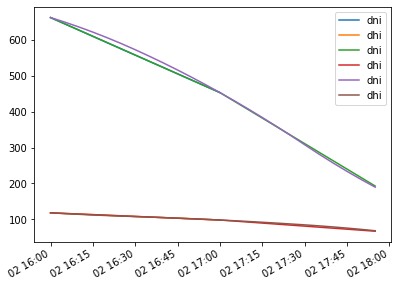

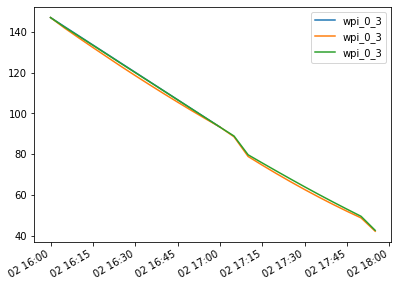

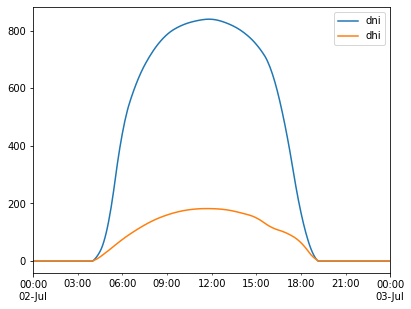

In [7]:
# initialize forecaster
forecaster = Forecast(config_path, facade_type=facade_type,
                      regenerate=False, filestruct=filestruct,
                      wpi_plot=False, wpi_loc=wpi_loc)


weather, info = read_tmy3(weather_path)
st = weather.index[int(len(weather.index)/2)].date() # select day in summer
hs = 16
he = 18

wf = weather.loc[st:st+pd.DateOffset(hours=24),]
data = forecaster.compute2(wf[['dni','dhi']].copy())
axw = wf[['dni','dhi']].iloc[hs*1:he*1].plot(ax=None)
#ax = data[['wpi_0_{}'.format(z) for z in range(4)]].iloc[16*1:18*1].plot(ax=None)
axr = data[['wpi_0_3']].iloc[hs*1:he*1].plot(ax=None)

weather1 = weather.copy().resample('5T').interpolate()
wf = weather1.loc[st:st+pd.DateOffset(hours=24),]
axw = wf[['dni','dhi']].iloc[hs*12:he*12].plot(ax=axw)
data = forecaster.compute2(wf[['dni','dhi']].copy())
#ax = data[['wpi_0_{}'.format(z) for z in range(4)]].iloc[16*12:18*12].plot(ax=ax)
axr = data[['wpi_0_3']].iloc[hs*12:he*12].plot(ax=axr)

weather2 = weather.copy().resample('5T').interpolate('quadratic')
wf = weather2.loc[st:st+pd.DateOffset(hours=24),]
wf.loc[wf[['dni','dhi']].sum(axis=1) < 5] = 0
axw = wf[['dni','dhi']].iloc[hs*12:he*12].plot(ax=axw)
data = forecaster.compute2(wf[['dni','dhi']].copy())
#ax = data[['wpi_0_{}'.format(z) for z in range(4)]].iloc[16*12:18*12].plot(ax=ax)
axr = data[['wpi_0_3']].iloc[hs*12:he*12].plot(ax=axr)

wf[['dni','dhi']].plot()
plt.show()

### Check Controller

In [8]:
# initialize forecaster
forecaster = Forecast(config_path, facade_type=facade_type,
                      regenerate=False, filestruct=filestruct,
                      wpi_plot=False, wpi_loc=wpi_loc)

# select weather (summer day)
weather, info = read_tmy3(weather_path)
weather = weather.resample('5T').interpolate()
st = weather.index[int(len(weather.index)/2)].date()

# controller parameter
parameter = default_parameter()

# compute forecast
wf = weather.loc[st:st+pd.DateOffset(hours=24),]
data = forecaster.compute2(wf[['dni','dhi']])

# run loop for each 6 hours (optional)
'''
data = pd.DataFrame()
sst = st
for i in range(4):
    wf = weather.loc[sst:sst+pd.DateOffset(hours=6), ['dni','dhi']]
    if data.empty:
        data = forecaster.compute2(wf)
    else:
        data = data.append(forecaster.compute2(wf))
    sst += pd.DateOffset(hours=6, minutes=1)
'''

# inputs for controller
data, parameter = compute_periods(data, get_e19_2020_tariff(), parameter)
data['oat'] = wf['temp_air']
data['wind_speed'] = wf['wind_speed']
b = 0
data['battery_{!s}_avail'.format(b)] = 0
data['battery_{!s}_demand'.format(b)] = 0
data['battery_reg'] = 0
data['wpi_min'] = 500
data['glare_max'] = 0.4
data['generation_pv'] = 0
data['load_demand'] = 0
data['temp_room_max'] = 24
data['temp_room_min'] = 20
data['temp_slab_max'] = 23
data['temp_slab_min'] = 21
data['temp_wall_max'] = 1e6
data['temp_wall_min'] = -1e6
#data['plugload'] = 10 # W
#data['occupant_load'] = 15 # W
data['plug_load'] = 50 # W
data['occupant_load'] = 0 # W
data['equipment'] = 100 # W
data['occupancy_light'] = 0.5 # 50 % occupancy

# resmaple to 5 min (optional)
'''
data = data.resample('5T').asfreq()
for c in data.columns:
    if c in ['load_demand','generation_pv','oat']:
        data[c] = data[c].interpolate()
    else:
        data[c] = data[c].ffill()
'''

# data

"\ndata = data.resample('5T').asfreq()\nfor c in data.columns:\n    if c in ['load_demand','generation_pv','oat']:\n        data[c] = data[c].interpolate()\n    else:\n        data[c] = data[c].ffill()\n"

### Check Rounding Cutoffs

In [9]:
stats = data.describe().transpose()
stats[(stats['std']>0) & ((stats['mean'] < 1e-1) | (stats['std'] < 1e-1))]

,count,mean,std,min,25%,50%,75%,max
abs2_0_0,289.0,0.044270,5.270389e-02,0.0,0.0,0.020661,0.083447,0.161014
abs2_1_0,289.0,0.044270,5.270389e-02,0.0,0.0,0.020661,0.083447,0.161014
iflr_2_0,289.0,0.096241,1.452597e-01,0.0,0.0,0.036812,0.130867,0.627935
abs2_2_0,289.0,0.044270,5.270389e-02,0.0,0.0,0.020661,0.083447,0.161014
glare_max,289.0,0.400000,5.560744e-17,0.4,0.4,0.400000,0.400000,0.400000


### Check Radiance Cutoffs

{'wpi': [5, 1000000.0], 'ev': [250, 1000000.0], 'shg': [0, 1000000.0], 'abs1': [50, 1000000.0], 'abs2': [5, 1000000.0], 'tsol': [5, 1000000.0], 'iflr': [5, 1000000.0]}


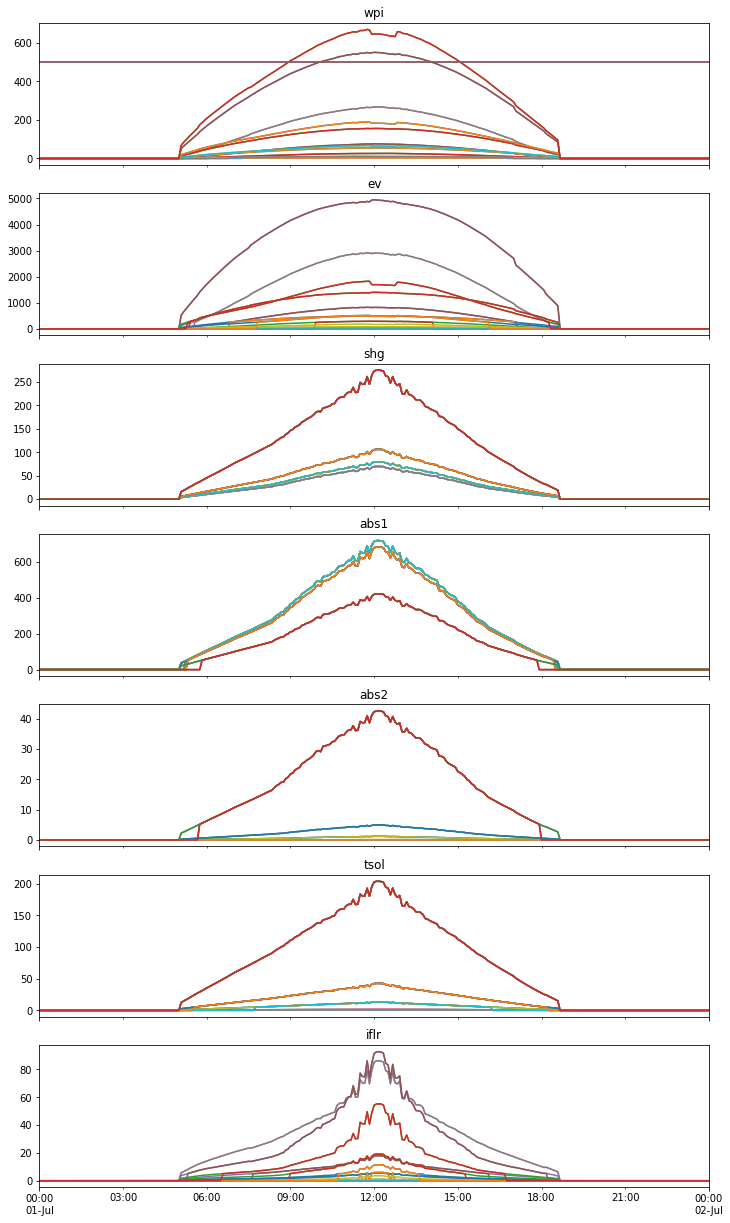

In [10]:
rad_cutoff = parameter['facade']['rad_cutoff']
print(rad_cutoff)

n = len(rad_cutoff.keys())
fig, axs = plt.subplots(n,1, figsize=(12, n*3), sharex=True, sharey=False)
axs = axs.ravel()
i = 0
for k in rad_cutoff.keys():
    for c in data.columns:
        if k in c:
            data[c].plot(ax=axs[i])
            t = data[c].mask(data[c] < rad_cutoff[k][0], 0).copy()
            t.mask(t > rad_cutoff[k][1], rad_cutoff[k][1]).plot(ax=axs[i], title=k)
    i += 1
plt.show()

### Run Optimization

In [11]:
# configure optimization
parameter['objective']['weight_view'] = 0
parameter['objective']['weight_actuation'] = 0.01

if not 'regulation_reserved_battery' in parameter['site'].keys():
    parameter['site']['regulation_reserved_battery'] = False
if not 'regulation_reserved_variable_battery' in parameter['site'].keys():
    parameter['site']['regulation_reserved_variable_battery'] = False
if not 'regulation_xor' in parameter['site'].keys():
    parameter['site']['regulation_xor'] = False
if not 'regulation_xor_building' in parameter['site'].keys():
    parameter['site']['regulation_xor_building'] = False
if not 'regulation_all' in parameter['site'].keys():
    parameter['site']['regulation_all'] = False
if not 'regulation_min' in parameter['site'].keys():
    parameter['site']['regulation_min'] = False
if not 'regulation_symmetric' in parameter['site'].keys():
    parameter['site']['regulation_symmetric'] = False

# apply new Radiance cutoff
rad_cutoff = parameter['facade']['rad_cutoff']
for k in rad_cutoff.keys():
    for c in data.columns:
        if k in c:
            data.loc[:,c] = data[c].mask(data[c] < rad_cutoff[k][0], 0)
            data.loc[:,c] = data[c].mask(data[c] > rad_cutoff[k][1], rad_cutoff[k][1])

# initilaize controller
solver_path = get_solver('cbc')
output_list = default_output_list(parameter)
smartDER = DOPER(model=control_model,
                 parameter=parameter,
                 solver_path=solver_path,
                 output_list=output_list)

# Note seconds = 15 s + threads x time
options = {'seconds': int(5*60), 'maxIterations': int(1e6), 
           'threads': int(1), 'slog': 0, 'log': 0} #, 'dualT': 1e-7, 'dualB': 1e7}
#res = smartDER.do_optimization(data, tee=False, options=options)

# compute variable timestep and tariff periods
test = resample_variable_ts(data.copy(deep=True), reduced_start=6*60, reduced_ts=60, cols_fill=[])
test, _ = compute_periods(test, get_e19_2020_tariff(), parameter)

# run optimizaiton
res = smartDER.do_optimization(test, tee=False, options=options)
duration, objective, df, model, result, termination, parameter = res
print(standard_report(res))
print('Zone actuation cost:', round(model.sum_zone_actuation.value, 1))
print('Zone glare cost:', round(model.sum_glare_penalty.value, 1))
print('Zone view cost:', round(model.sum_view_penalty.value, 1))

Duration [s]		0.8
Objective [$]		16.53			7.46 (Total Cost)
Cost [$]		9.35 (Energy)	7.04 (Demand)
CO2 Emissions [kg]		0.0

Zone actuation cost: 14.0
Zone glare cost: 3.8
Zone view cost: 3.6


### Check Variable Timestep

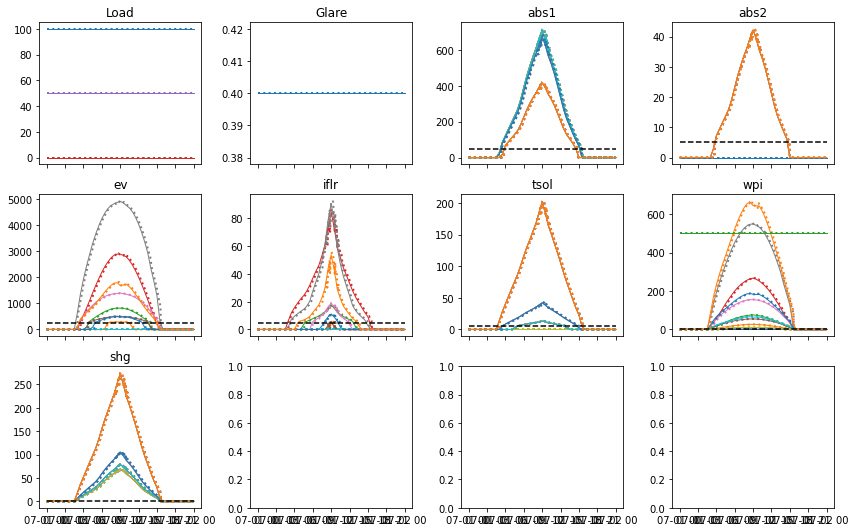

In [12]:
test = resample_variable_ts(data.copy(deep=True), reduced_start=60, reduced_ts=30, cols_fill=[])

cols = []
#cols.append(['dni','dhi'])
#cols.append(['temp_air','oat','temp_room_max','temp_room_min',
#             'temp_slab_max','temp_slab_min'])
#cols.append(['battery_0_avail','battery_0_demand','battery_reg'])
cols.append(['equipment','generation_pv','load_demand','occupant_load','plug_load'])
cols.append(['glare_max'])
cols.append([c for c in data.columns if 'abs1' in c])
cols.append([c for c in data.columns if 'abs2' in c])
cols.append([c for c in data.columns if 'ev' in c])
cols.append([c for c in data.columns if 'iflr' in c])
cols.append([c for c in data.columns if 'tsol' in c])
cols.append([c for c in data.columns if 'wpi' in c])
cols.append([c for c in data.columns if 'shg' in c])
#title = ['Solar','Temperature','Battery']
title = []
title += ['Load','Glare','abs1','abs2','ev','iflr','tsol','wpi','shg']

rows = int(round(len(cols)/4 + 0.49))
fig, axs = plt.subplots(rows, 4, figsize=(12, rows*2.5), sharex=True, sharey=False)
axs = axs.ravel()
i = 0
for c in cols:
    ci = 0
    for k in c:
        axs[i].plot(data[k], color='C{}'.format(ci), linestyle=':', linewidth=2)
        axs[i].plot(test[k], color='C{}'.format(ci), linestyle='-', linewidth=1)
        ci += 1
    if title[i] in parameter['facade']['rad_cutoff'].keys():
        axs[i].plot(test.index, [parameter['facade']['rad_cutoff'][title[i]][0]]*len(test),
                    color='black', linestyle='--')
    axs[i].set_title(title[i])
    i += 1
plt.tight_layout()
plt.show()

In [13]:
# make list of variable timesteps to explore
var_ts = pd.DataFrame([(24, 5)]+list(itertools.product(range(0, 12+2, 2), [15, 30, 60])),
                      columns=['reduced_start','reduced_ts'])

# initialize the controller
smartDER = DOPER(model=control_model,
                 parameter=parameter,
                 solver_path=solver_path,
                 pyomo_logger=logging.ERROR,
                 output_list=output_list)

# iterate through variable timestep combinations
for ix in var_ts.index:
    test = resample_variable_ts(data.copy(deep=True),
                                reduced_start=int(var_ts.loc[ix,'reduced_start']*60),
                                reduced_ts=int(var_ts.loc[ix,'reduced_ts']), cols_fill=[])
    test, _ = compute_periods(test, get_e19_2020_tariff(), parameter)
    options = {'seconds': int(1*60)}
    res = smartDER.do_optimization(test, tee=False, options=options, print_error=False)
    duration, objective, df, model, result, termination, parameter = res
    var_ts.loc[ix, 'duration'] = duration
    var_ts.loc[ix, 'energy'] = model.sum_energy_cost.value * parameter['objective']['weight_energy']
    var_ts.loc[ix, 'demand'] = model.sum_demand_cost.value * parameter['objective']['weight_demand']

In [14]:
var_ts

,reduced_start,reduced_ts,duration,energy,demand
0,24,5,60.830421,9.796272,7.185995
1,0,15,33.847133,9.633586,7.066120
2,0,30,2.138666,9.550738,7.062288
3,0,60,1.304574,9.352136,7.040236
4,2,15,26.444669,9.633623,7.066148
5,2,30,2.461055,9.550833,7.062369
6,2,60,0.582191,9.352348,7.040424
7,4,15,27.289482,9.633651,7.066165
8,4,30,4.869528,9.550903,7.062416
9,4,60,0.670679,9.352509,7.040527
